In [14]:
import os
import random
import time
import copy

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ViT_B_16_Weights
from torchvision.models import Swin_T_Weights, swin_t
from torchvision.transforms import InterpolationMode

In [2]:
# Configuració
RANDOM_SEED   = 123
NUM_CLASSES   = 2
BATCH_SIZE    = 32
EPOCHS        = 30
PATIENCE      = 5
K_FOLDS       = 5
PARAM_GRID    = {'lr': [1e-4, 5e-5], 'weight_decay': [0, 1e-2]}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
# directoris
dataset_dir = "/kaggle/input/dataset-v2/dataset"
classes     = ['0', '1']

In [4]:
# etiquetes
all_paths, all_labels = [], []
for lbl in classes:
    fld = os.path.join(dataset_dir, lbl)
    for fn in os.listdir(fld):
        if fn.lower().endswith(".png"):
            all_paths.append(os.path.join(fld, fn))
            all_labels.append(int(lbl))

In [5]:
# dataset i transformacions
class MammoDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths     = paths
        self.labels    = labels
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]


train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(degrees=15, interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224, scale=(0.9, 1.0), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [6]:
# funció d'entrenament i validació
def train_model_balanced(model, criterion, optimizer, scheduler, dl_train, dl_val):
    best_wts = copy.deepcopy(model.state_dict())
    best_bal_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(EPOCHS):
        # Entrenament
        model.train()
        y_true_tr, y_pred_tr = [], []
        for x, y in dl_train:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(out, dim=1)
            y_true_tr += y.cpu().tolist()
            y_pred_tr += preds.cpu().tolist()

        # Validació
        model.eval()
        y_true_va, y_pred_va = [], []
        with torch.no_grad():
            for x, y in dl_val:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                preds = torch.argmax(out, dim=1)
                y_true_va += y.cpu().tolist()
                y_pred_va += preds.cpu().tolist()

        val_bal_acc = balanced_accuracy_score(y_true_va, y_pred_va)
        val_acc     = accuracy_score(y_true_va, y_pred_va)
        print(f"Epoch {epoch+1}: Val Balanced Acc={val_bal_acc:.4f}, Acc={val_acc:.4f}")

        # Early stopping
        if val_bal_acc > best_bal_acc:
            best_bal_acc = val_bal_acc
            best_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print("Early stopping.")
                break

        if scheduler:
            scheduler.step()

    model.load_state_dict(best_wts)
    return model

In [7]:
# Grid searh i K-fold
start_time = time.time()
grid = list(ParameterGrid(PARAM_GRID))
best_cfg = None
best_mean_bal = 0.0
best_all_true, best_all_pred = [], []

for cfg in grid:
    lr = cfg['lr']
    wd = cfg['weight_decay']
    fold_balances = []
    all_true, all_pred = [], []

    print(f"\nTesting cfg: lr={lr}, weight_decay={wd}")
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels), 1):
        # Oversample classe minoritaria (només entrenament)
        train_labels = [all_labels[i] for i in train_idx]
        counts = np.bincount(train_labels, minlength=NUM_CLASSES)
        c0, c1 = counts
        n_aug = max(0, c0 - c1)
        min_idx = [i for i in train_idx if all_labels[i] == 1]
        aug_idx = list(np.random.choice(min_idx, n_aug, replace=True))
        train_idx_bal = list(train_idx) + aug_idx

        train_paths = [all_paths[i] for i in train_idx_bal]
        train_lbls  = [all_labels[i] for i in train_idx_bal]
        val_paths   = [all_paths[i] for i in val_idx]
        val_lbls    = [all_labels[i] for i in val_idx]

        # DataLoaders
        ds_tr = MammoDataset(train_paths, train_lbls, transform=train_transform)
        ds_va = MammoDataset(val_paths,   val_lbls,  transform=test_transform)
        dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

        # Model
        model = models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
        in_f   = model.heads.head.in_features
        model.heads.head = nn.Linear(in_f, NUM_CLASSES)
        model.to(DEVICE)

        # Loss amb pesos inversos
        total = len(train_lbls)
        w0 = total / (NUM_CLASSES * train_lbls.count(0))
        w1 = total / (NUM_CLASSES * train_lbls.count(1))
        crit = nn.CrossEntropyLoss(weight=torch.tensor([w0, w1], device=DEVICE))

        opt   = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        sched = optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

        # Entrenar
        model = train_model_balanced(model, crit, opt, sched, dl_tr, dl_va)

        # Evaluar
        trues, preds = [], []
        model.eval()
        with torch.no_grad():
            for x, y in dl_va:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                p = torch.argmax(out, dim=1)
                trues += y.cpu().tolist()
                preds += p.cpu().tolist()

        bal_acc = balanced_accuracy_score(trues, preds)
        fold_balances.append(bal_acc)
        all_true += trues
        all_pred += preds
        print(f"  Fold {fold}: Balanced Acc={bal_acc:.4f}")

    mean_bal = np.mean(fold_balances)
    print(f" >> Mean Balanced Acc for cfg: {mean_bal:.4f}")
    if mean_bal > best_mean_bal:
        best_mean_bal = mean_bal
        best_cfg = cfg
        best_all_true = all_true
        best_all_pred = all_pred

total_time = time.time() - start_time
print(f"\nBest cfg: {best_cfg}, Mean Balanced Acc={best_mean_bal:.4f}")
print(f"Total training time: {total_time/60:.1f} minutes")


Testing cfg: lr=0.0001, weight_decay=0


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 180MB/s] 


Epoch 1: Val Balanced Acc=0.5000, Acc=0.2439
Epoch 2: Val Balanced Acc=0.6355, Acc=0.5000
Epoch 3: Val Balanced Acc=0.6435, Acc=0.5122
Epoch 4: Val Balanced Acc=0.6710, Acc=0.7073
Epoch 5: Val Balanced Acc=0.5250, Acc=0.7683
Epoch 6: Val Balanced Acc=0.6056, Acc=0.6341
Epoch 7: Val Balanced Acc=0.5065, Acc=0.3049
Epoch 8: Val Balanced Acc=0.6839, Acc=0.8293
Epoch 9: Val Balanced Acc=0.7210, Acc=0.7317
Epoch 10: Val Balanced Acc=0.7363, Acc=0.7805
Epoch 11: Val Balanced Acc=0.7185, Acc=0.8049
Epoch 12: Val Balanced Acc=0.7444, Acc=0.7927
Epoch 13: Val Balanced Acc=0.6952, Acc=0.7439
Epoch 14: Val Balanced Acc=0.6871, Acc=0.7317
Epoch 15: Val Balanced Acc=0.7355, Acc=0.8049
Epoch 16: Val Balanced Acc=0.7516, Acc=0.8293
Epoch 17: Val Balanced Acc=0.7516, Acc=0.8293
Epoch 18: Val Balanced Acc=0.7516, Acc=0.8293
Epoch 19: Val Balanced Acc=0.7516, Acc=0.8293
Epoch 20: Val Balanced Acc=0.7516, Acc=0.8293
Epoch 21: Val Balanced Acc=0.7516, Acc=0.8293
Early stopping.
  Fold 1: Balanced Acc=0.75


Confusion Matrix (best cfg, aggregated val folds):
[[258  52]
 [ 28  72]]


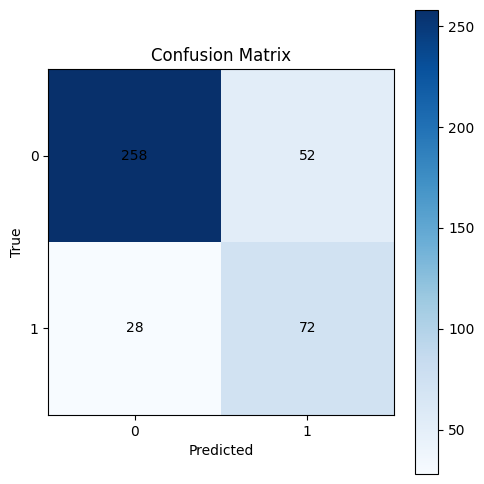

In [8]:
# Matriu de confusió
cm = confusion_matrix(best_all_true, best_all_pred)
print("\nConfusion Matrix (best cfg, aggregated val folds):")
print(cm)
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0,1], ['0','1'])
plt.yticks([0,1], ['0','1'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.colorbar()
plt.tight_layout()
plt.show()


Exemples d'augment de dades (rotacions ±15°):


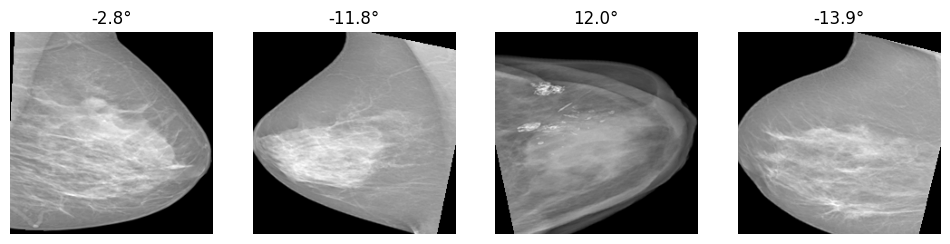

In [9]:
print("\nExemples d'augment de dades (rotacions ±15°):")
min_folder = os.path.join(dataset_dir, '1')
examples = random.sample(
    [os.path.join(min_folder, f) for f in os.listdir(min_folder) if f.lower().endswith('.png')],
    4
)
fig, axs = plt.subplots(1,4, figsize=(12,3))
for ax, p in zip(axs, examples):
    img = Image.open(p).convert('L')
    angle = random.uniform(-15,15)
    rot = img.rotate(angle, resample=Image.BICUBIC)
    ax.imshow(rot, cmap='gray')
    ax.set_title(f"{angle:.1f}°")
    ax.axis('off')
plt.show()

In [12]:
# Guardem model
save_dir = "/kaggle/working/"
os.makedirs(save_dir, exist_ok=True)

# Model complet per facilitar la càrrega
full_model_path = os.path.join(save_dir, "vit_full_model.pth")
torch.save(model, full_model_path)
print(f"Model complet guardat a: {full_model_path}")

Model complet guardat a: /kaggle/working/vit_full_model.pth


In [15]:
# Grid searh i K-fold
start_time = time.time()
grid = list(ParameterGrid(PARAM_GRID))
best_cfg = None
best_mean_bal = 0.0
best_all_true, best_all_pred = [], []

for cfg in grid:
    lr = cfg['lr']
    wd = cfg['weight_decay']
    fold_balances = []
    all_true, all_pred = [], []

    print(f"\nTesting cfg: lr={lr}, weight_decay={wd}")
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels), 1):
        # Oversample classe minoritaria (només entrenament)
        train_labels = [all_labels[i] for i in train_idx]
        counts = np.bincount(train_labels, minlength=NUM_CLASSES)
        c0, c1 = counts
        n_aug = max(0, c0 - c1)
        min_idx = [i for i in train_idx if all_labels[i] == 1]
        aug_idx = list(np.random.choice(min_idx, n_aug, replace=True))
        train_idx_bal = list(train_idx) + aug_idx

        train_paths = [all_paths[i] for i in train_idx_bal]
        train_lbls  = [all_labels[i] for i in train_idx_bal]
        val_paths   = [all_paths[i] for i in val_idx]
        val_lbls    = [all_labels[i] for i in val_idx]

        # DataLoaders
        ds_tr = MammoDataset(train_paths, train_lbls, transform=train_transform)
        ds_va = MammoDataset(val_paths,   val_lbls,  transform=test_transform)
        dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

        # Model SwTransformer
        model = swin_t(weights=Swin_T_Weights.DEFAULT)
        in_f = model.head.in_features
        model.head = nn.Linear(in_f, NUM_CLASSES)
        model.to(DEVICE)

        # Loss amb pesos inversos
        total = len(train_lbls)
        w0 = total / (NUM_CLASSES * train_lbls.count(0))
        w1 = total / (NUM_CLASSES * train_lbls.count(1))
        crit = nn.CrossEntropyLoss(weight=torch.tensor([w0, w1], device=DEVICE))

        opt   = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        sched = optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

        # Entrenar
        model = train_model_balanced(model, crit, opt, sched, dl_tr, dl_va)

        # Evaluar
        trues, preds = [], []
        model.eval()
        with torch.no_grad():
            for x, y in dl_va:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                p = torch.argmax(out, dim=1)
                trues += y.cpu().tolist()
                preds += p.cpu().tolist()

        bal_acc = balanced_accuracy_score(trues, preds)
        fold_balances.append(bal_acc)
        all_true += trues
        all_pred += preds
        print(f"  Fold {fold}: Balanced Acc={bal_acc:.4f}")

    mean_bal = np.mean(fold_balances)
    print(f" >> Mean Balanced Acc for cfg: {mean_bal:.4f}")
    if mean_bal > best_mean_bal:
        best_mean_bal = mean_bal
        best_cfg = cfg
        best_all_true = all_true
        best_all_pred = all_pred

total_time = time.time() - start_time
print(f"\nBest cfg: {best_cfg}, Mean Balanced Acc={best_mean_bal:.4f}")
print(f"Total training time: {total_time/60:.1f} minutes")


Testing cfg: lr=0.0001, weight_decay=0


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 212MB/s] 


Epoch 1: Val Balanced Acc=0.5000, Acc=0.7561
Epoch 2: Val Balanced Acc=0.5000, Acc=0.7561
Epoch 3: Val Balanced Acc=0.4468, Acc=0.3171
Epoch 4: Val Balanced Acc=0.5000, Acc=0.2439
Epoch 5: Val Balanced Acc=0.5613, Acc=0.4390
Epoch 6: Val Balanced Acc=0.5500, Acc=0.7805
Epoch 7: Val Balanced Acc=0.6839, Acc=0.8293
Epoch 8: Val Balanced Acc=0.7371, Acc=0.7561
Epoch 9: Val Balanced Acc=0.7210, Acc=0.7317
Epoch 10: Val Balanced Acc=0.7532, Acc=0.7805
Epoch 11: Val Balanced Acc=0.7290, Acc=0.7439
Epoch 12: Val Balanced Acc=0.7290, Acc=0.7439
Epoch 13: Val Balanced Acc=0.7371, Acc=0.7561
Epoch 14: Val Balanced Acc=0.7444, Acc=0.7927
Epoch 15: Val Balanced Acc=0.7444, Acc=0.7927
Early stopping.
  Fold 1: Balanced Acc=0.7532
Epoch 1: Val Balanced Acc=0.5605, Acc=0.4634
Epoch 2: Val Balanced Acc=0.7468, Acc=0.7195
Epoch 3: Val Balanced Acc=0.7089, Acc=0.8415
Epoch 4: Val Balanced Acc=0.8355, Acc=0.8537
Epoch 5: Val Balanced Acc=0.6500, Acc=0.8293
Epoch 6: Val Balanced Acc=0.7427, Acc=0.8415
Epo


Confusion Matrix SwTransformer (best cfg, aggregated val folds):
[[267  43]
 [ 22  78]]


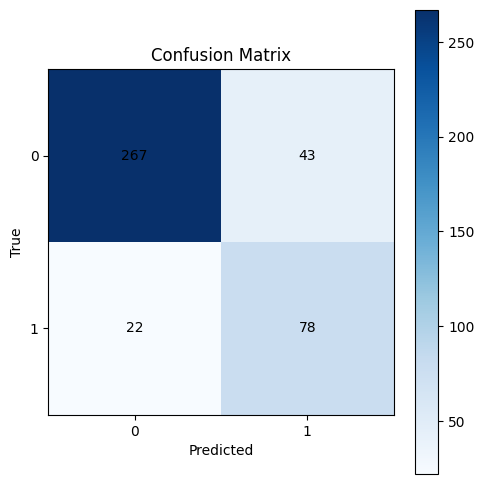

In [16]:
# Matriu de confusió
cm = confusion_matrix(best_all_true, best_all_pred)
print("\nConfusion Matrix SwTransformer (best cfg, aggregated val folds):")
print(cm)
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0,1], ['0','1'])
plt.yticks([0,1], ['0','1'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.colorbar()
plt.tight_layout()
plt.show()

In [17]:
# Guardem model
save_dir = "/kaggle/working/"
os.makedirs(save_dir, exist_ok=True)

# Model complet per facilitar la càrrega
full_model_path = os.path.join(save_dir, "swtransformer_full_model.pth")
torch.save(model, full_model_path)
print(f"Model complet guardat a: {full_model_path}")

Model complet guardat a: /kaggle/working/swtransformer_full_model.pth
